In [1]:
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
mlp_df = 'mlp_results.csv'
kan_df = 'kan_results.csv'

In [6]:
mlp_df = pd.read_csv(mlp_df)
kan_df = pd.read_csv(kan_df)

In [9]:
print(mlp_df.columns)
mlp_df.head()

Index(['epoch', ' train_acc', ' test_acc', ' time'], dtype='object')


,epoch,train_acc,test_acc,time
0,0,0.904247,0.910256,25.75
1,2,0.933443,0.934195,38.61
2,4,0.940087,0.940004,38.58
3,6,0.943960,0.948618,38.14
4,8,0.946247,0.947015,37.17


Text(0.5, 1.0, 'MNIST Training Time using HSIC Bottleneck Training')

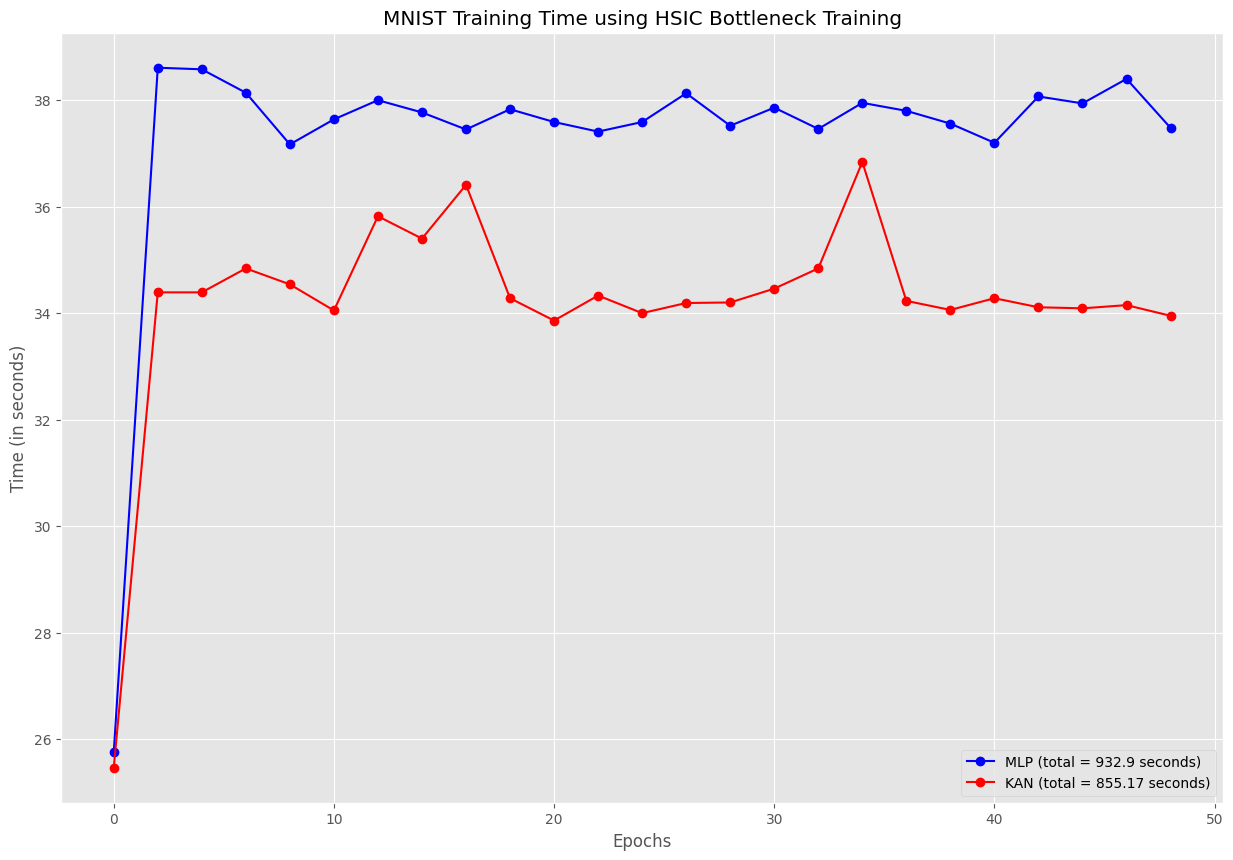

In [38]:
import numpy as np

plt.style.use('ggplot')
plt.subplots(figsize = (15,10))
epochs = mlp_df['epoch']
total_mlp = np.sum(mlp_df[' time']).round(2)
total_kan = np.sum(kan_df[' time']).round(2)

plt.plot(epochs, mlp_df[' time'], color = 'blue', label = 'MLP (total = ' + str(total_mlp) + " seconds)", marker = 'o')
plt.plot(epochs, kan_df[' time'], color = 'red', label = 'KAN (total = ' + str(total_kan) + " seconds)", marker = 'o')

plt.xlabel("Epochs")
plt.ylabel("Time (in seconds)")
plt.legend()
plt.title("MNIST Training Time using HSIC Bottleneck Training")

In [5]:
import pandas as pd
import numpy as np
import os
print(os.getcwd())
RESULTS_FOLDER = '..//Results2/'
result_files = [os.path.join(RESULTS_FOLDER, x) for x in os.listdir(RESULTS_FOLDER) if x.endswith('.csv') and 'optimizer' in x]
result_rows = []
for r in result_files:
    
    filename = os.path.split(r)[-1]
    #print("Processing: ", filename)

    
        

    # Extract relevent information from filename
    params = filename.replace(".csv", "").split("_")
    dataset = params[0]

    if 'FASHION_MNIST' in filename:
        dataset = 'FASHION'
        filename = '_'.join(filename.split("_")[1:])
        params = filename.replace(".csv", "").split("_")
        
    backprop = params[1]
    model = params[2]
    num_layers = params[3]

    activation = params[5]

    if 'degree' in params[6]:
        degree = params[7]
        batchsize = params[9]
        lr = params[11]
        num_parameters = params[15]
    else:
        degree = 3
        batchsize = params[7]
        lr = params[9]
        num_parameters = params[13]

    #print(init, "----------------")
    # Get best test performance and when it was reached
    try:
        data = pd.read_csv(r)
    except FileNotFoundError:
        print("Could not read: ", r)
        continue
    best_perf_test =  np.max(data['Test_loss'])
    best_perf_train = np.max(data['Train_loss'])
    best_perf_epoch_test = np.where(data['Test_loss'] == best_perf_test)[0][0]
    epochs = np.max(data['Epoch'])

    generalization = data['Train_loss'] - data['Test_loss']
    avg_gen = np.mean(generalization)
    # Get the average time taken per epoch
    avg_time = np.mean(data['Time'])

    result_rows.append([dataset, backprop, model, degree, lr, num_layers, batchsize, lr, num_parameters, best_perf_train, best_perf_test, best_perf_epoch_test, avg_time, avg_gen, activation])


df = pd.DataFrame(result_rows)
df.columns = ["Dataset", "Backprop", "Model", "Degree", "LearningRate", "Num_layers", "Batchsize", "LearningRate", "Num_parameters", "Best_train", "Best_test", "Best_test_at", "Avg_time",  "AvgGenError", "Activation"]

print(df.head())


C:\Users\shairozs\Documents\Projects\HSIC_Bottleneck-Pytorch\Notebooks
  Dataset  Backprop Model Degree LearningRate Num_layers Batchsize  \
0   CIFAR  backprop   kan      3       0.0005    4layers      2048   
1   CIFAR  backprop   kan      3       0.0005    4layers      2048   
2   CIFAR  backprop   kan      3       0.0005    4layers      2048   
3   CIFAR  backprop   kan      2       0.0005    4layers      2048   
4   CIFAR  backprop   kan      3       0.0005    4layers      2048   

  LearningRate Num_parameters  Best_train  Best_test  Best_test_at   Avg_time  \
0       0.0005       38040084    0.992188   0.542847            49  39.668692   
1       0.0005       38040084    0.996948   0.570557            49  39.909724   
2       0.0005       38040084    0.999593   0.571411            47  42.425428   
3       0.0005       34236436    0.999349   0.566772            49  27.219320   
4       0.0005       38040084    0.999349   0.571655            48  53.475389   

   AvgGenError Activa

In [6]:
#df.Degree = df.Degree.astype('uint8')
df[df.Dataset == 'CIFAR'][df.Model=='kan'][df.Backprop=='backprop'].sort_values('Num_layers')

C:\Users\shairozs\AppData\Local\Temp\1\ipykernel_32436\1639396077.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df.Dataset == 'CIFAR'][df.Model=='kan'][df.Backprop=='backprop'].sort_values('Num_layers')
C:\Users\shairozs\AppData\Local\Temp\1\ipykernel_32436\1639396077.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df.Dataset == 'CIFAR'][df.Model=='kan'][df.Backprop=='backprop'].sort_values('Num_layers')


,Dataset,Backprop,Model,Degree,LearningRate,Num_layers,Batchsize,LearningRate,Num_parameters,Best_train,Best_test,Best_test_at,Avg_time,AvgGenError,Activation
0,CIFAR,backprop,kan,3,0.0005,4layers,2048,0.0005,38040084,0.992188,0.542847,49,39.668692,0.293681,ELU
1,CIFAR,backprop,kan,3,0.0005,4layers,2048,0.0005,38040084,0.996948,0.570557,49,39.909724,0.307149,GELU
2,CIFAR,backprop,kan,3,0.0005,4layers,2048,0.0005,38040084,0.999593,0.571411,47,42.425428,0.313949,SiLU
3,CIFAR,backprop,kan,2,0.0005,4layers,2048,0.0005,34236436,0.999349,0.566772,49,27.219320,0.315778,SiLU
4,CIFAR,backprop,kan,3,0.0005,4layers,2048,0.0005,38040084,0.999349,0.571655,48,53.475389,0.307590,SiLU
5,CIFAR,backprop,kan,4,0.0005,4layers,2048,0.0005,41843732,0.999471,0.570557,48,64.907744,0.308398,SiLU
6,CIFAR,backprop,kan,5,0.0005,4layers,2048,0.0005,45647380,0.999634,0.578613,47,31.043828,0.305880,SiLU


C:\Users\shairozs\AppData\Local\Temp\1\ipykernel_37896\981740648.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\shairozs\AppData\Local\Temp\1\ipykernel_37896\981740648.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


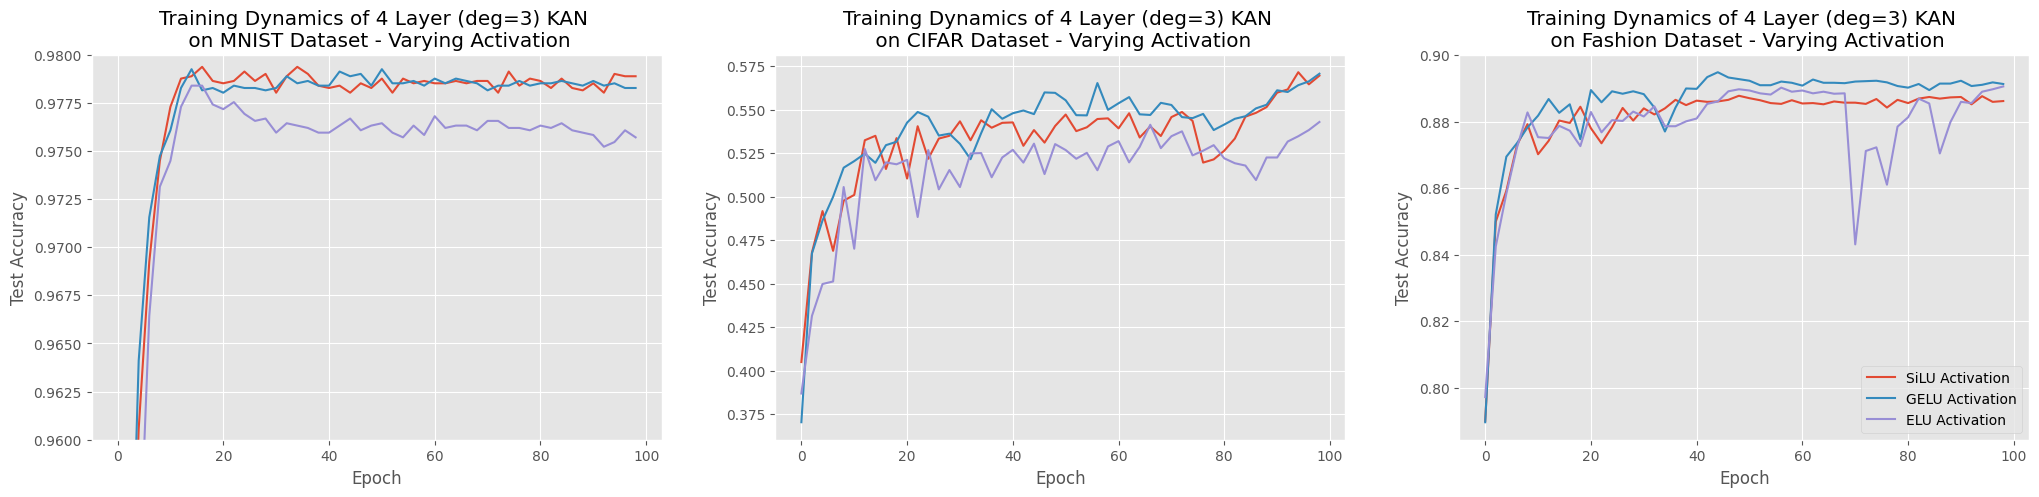

In [22]:
fig, axes = plt.subplots(1,3, figsize = (25,5))
i = 0
for ds in ['MNIST', 'CIFAR', 'Fashion']: 

    if ds == 'MNIST':
        df_silu = pd.read_csv('../Results2/MNIST_backprop_kan_4layers_activation_SiLU_degree_2_batchsize_2048_lr_0.0005_epochs_100_parameters_998676_optimizer_AdamW_init_orthogonal_.csv')
        df_gelu = pd.read_csv('../Results2/MNIST_backprop_kan_4layers_activation_GELU_degree_3_batchsize_2048_lr_0.0005_epochs_100_parameters_1109588_optimizer_AdamW_init_orthogonal_.csv')
        df_elu = pd.read_csv('../Results2/MNIST_backprop_kan_4layers_activation_ELU_degree_3_batchsize_2048_lr_0.0005_epochs_100_parameters_1109588_optimizer_AdamW_init_orthogonal_.csv')

    elif ds == 'CIFAR':
        df_silu = pd.read_csv('../Results2/CIFAR_backprop_kan_4layers_activation_SiLU_batchsize_2048_lr_0.0005_epochs_100_parameters_38040084_optimizer_AdamW_init_orthogonal_.csv')
        df_gelu = pd.read_csv('../Results2/CIFAR_backprop_kan_4layers_activation_GELU_batchsize_2048_lr_0.0005_epochs_100_parameters_38040084_optimizer_AdamW_init_orthogonal_.csv')
        df_elu = pd.read_csv('../Results2/CIFAR_backprop_kan_4layers_activation_ELU_batchsize_2048_lr_0.0005_epochs_100_parameters_38040084_optimizer_AdamW_init_orthogonal_.csv')


    elif ds == 'IMDB':
        df_silu = pd.read_csv('../Results2/IMDB_backprop_kan_4layers_activation_SiLU_degree_3_batchsize_2048_lr_0.0005_epochs_100_parameters_231492_optimizer_AdamW_init_orthogonal_.csv')
        df_gelu = pd.read_csv('../Results2/IMDB_backprop_kan_4layers_activation_GELU_degree_3_batchsize_2048_lr_0.0005_epochs_100_parameters_231492_optimizer_AdamW_init_orthogonal_.csv')
        df_elu = pd.read_csv('../Results2/IMDB_backprop_kan_4layers_activation_ELU_degree_3_batchsize_2048_lr_0.0005_epochs_100_parameters_231492_optimizer_AdamW_init_orthogonal_.csv')

    elif ds == 'Fashion':
        df_silu = pd.read_csv('../Results2/FASHION_MNIST_backprop_kan_4layers_activation_SiLU_degree_3_batchsize_2048_lr_0.0005_epochs_100_parameters_1109588_optimizer_AdamW_init_orthogonal_.csv')
        df_gelu = pd.read_csv('../Results2/FASHION_MNIST_backprop_kan_4layers_activation_GELU_degree_3_batchsize_2048_lr_0.0005_epochs_100_parameters_1109588_optimizer_AdamW_init_orthogonal_.csv')
        df_elu = pd.read_csv('../Results2/FASHION_MNIST_backprop_kan_4layers_activation_ELU_degree_3_batchsize_2048_lr_0.0005_epochs_100_parameters_1109588_optimizer_AdamW_init_orthogonal_.csv')
    plt.style.use('ggplot')

    axes[i].set_ylim(0.96, 0.98) if i==0 else ""
    epochs = [x*2 for x in range(len(df_silu))]
    axes[i].plot(epochs, df_silu.Test_loss, label = 'SiLU Activation')
    axes[i].plot(epochs, df_gelu.Test_loss, label = 'GELU Activation')
    axes[i].plot(epochs, df_elu.Test_loss, label = 'ELU Activation')
    #plt.plot(epochs, df_relu.Test_loss, label = 'RELU Activation')
    axes[i].set_title(f"Training Dynamics of 4 Layer (deg=3) KAN \n on {ds} Dataset - Varying Activation")
    axes[i].set_ylabel("Test Accuracy")
    axes[i].set_xlabel("Epoch")
    #axes[i].set_xticks(list(range(0, 100, 2)))
    i += 1

    plt.legend()

In [ ]:
df_silu = pd.read_csv('../Results2/MNIST_backprop_kan_4layers_activation_SiLU_degree_2_batchsize_2048_lr_0.0005_epochs_100_parameters_998676_optimizer_AdamW_init_orthogonal_.csv')
df_gelu = pd.read_csv('../Results2/MN')
df_elu = pd.read_csv('../Results2/CIFAR_backprop_kan_4layers_activation_ELU_batchsize_2048_lr_0.0005_epochs_100_parameters_38040084_optimizer_AdamW_init_orthogonal_.csv')
#df_relu = pd.read_csv('../../dsfs/Results_New/CIFAR10_backprop_kan_4layers_batchsize_2048_lr_0.0005_epochs_100_parameters_38040084_optimizer_Adam_init_orthogonal_.csv')

plt.style.use('ggplot')
epochs = [x for x in range(len(df_silu))]
plt.plot(epochs, df_silu.Test_loss, label = 'SiLU Activation')
plt.plot(epochs, df_gelu.Test_loss, label = 'GELU Activation')
plt.plot(epochs, df_elu.Test_loss, label = 'ELU Activation')
#plt.plot(epochs, df_relu.Test_loss, label = 'RELU Activation')
plt.title("Performance of 4 Layer KAN on CIFAR10 Dataset")
plt.ylabel("Test loss")
plt.xlabel("Epoch")
plt.legend()

In [56]:
import numpy as np
two_layers_degree_three = np.max(pd.read_csv('../Results/Fashion_backprop_kan_2layers_batchsize_4096_lr_0.0005_epochs_100_parameters_254164_optimizer_Adam_init_kaiming_normal_.csv')['Test_loss']); print(two_layers_degree_three)
three_layers_degree_three = np.max(pd.read_csv('../Results/Fashion_backprop_kan_3layers_batchsize_4096_lr_0.0005_epochs_100_parameters_525652_optimizer_Adam_init_kaiming_normal_.csv')['Test_loss']); print(three_layers_degree_three)
four_layers_degree_two = np.max(pd.read_csv('../Results2/FASHION_MNIST_backprop_kan_4layers_activation_SiLU_degree_2_batchsize_2048_lr_0.0005_epochs_100_parameters_998676_optimizer_AdamW_init_orthogonal_.csv')['Test_loss']); print(four_layers_degree_two)
four_layers_degree_three = 0.88 ; print(four_layers_degree_three)#np.max(pd.read_csv('../Results/Fashion_backprop_kan_4layers_batchsize_4096_lr_0.0005_epochs_100_parameters_1109588_optimizer_Adam_init_kaiming_uniform_.csv')['Test_loss']); print(four_layers_degree_three)
four_layers_degree_four = np.max(pd.read_csv('../Results2/FASHION_MNIST_backprop_kan_4layers_activation_SiLU_degree_4_batchsize_2048_lr_0.0005_epochs_100_parameters_1220500_optimizer_AdamW_init_orthogonal_.csv')['Test_loss']); print(four_layers_degree_four)
four_layers_degree_five = np.max(pd.read_csv('../Results2/FASHION_MNIST_backprop_kan_4layers_activation_SiLU_degree_5_batchsize_2048_lr_0.0005_epochs_100_parameters_1331412_optimizer_AdamW_init_orthogonal_.csv')['Test_loss']); print(four_layers_degree_five)

0.86816406
0.8006592
0.8864746
0.88
0.8892822
0.890625


In [94]:
# Dataset, Num Layers, Degree Best_test, Num_parameters
rows = [['FashionMNIST', 2, 3, 0.8681, 7890452],
['FashionMNIST', 3, 3, 0.870, 17066516],
['FashionMNIST', 4, 2, 0.886, 34236436],
['FashionMNIST', 4, 3, 0.88, 3809034],
['FashionMNIST', 4, 4, 0.889, 41843732],
['FashionMNIST', 4, 5, 0.890, 45647380]]

degdf0 = pd.DataFrame(rows)
degdf0.columns = ['Dataset', 'NumLayers', 'Degree', 'Best_test', 'Num_parameters']
degdf0#[degdf.Degree == 3]

,Dataset,NumLayers,Degree,Best_test,Num_parameters
0,FashionMNIST,2,3,0.8681,7890452
1,FashionMNIST,3,3,0.8700,17066516
2,FashionMNIST,4,2,0.8860,34236436
3,FashionMNIST,4,3,0.8800,3809034
4,FashionMNIST,4,4,0.8890,41843732
5,FashionMNIST,4,5,0.8900,45647380


In [34]:
import numpy as np
two_layers_degree_three = np.max(pd.read_csv('../Results/MNIST_backprop_kan_2layers_batchsize_4096_lr_0.0005_epochs_100_parameters_254080_optimizer_Adam_init_kaiming_normal_.csv')['Test_loss']); print(two_layers_degree_three)
three_layers_degree_three = np.max(pd.read_csv('../Results/MNIST_backprop_kan_3layers_batchsize_4096_lr_0.0005_epochs_100_parameters_525440_optimizer_Adam_init_kaiming_normal_.csv')['Test_loss']); print(three_layers_degree_three)
four_layers_degree_two = np.max(pd.read_csv('../Results2/MNIST_backprop_kan_4layers_activation_SiLU_degree_2_batchsize_2048_lr_0.0005_epochs_100_parameters_998676_optimizer_AdamW_init_orthogonal_.csv')['Test_loss']); print(four_layers_degree_two)
four_layers_degree_three = np.max(pd.read_csv('../Results/MNIST_backprop_kan_4layers_batchsize_4096_lr_0.0005_epochs_100_parameters_1109120_optimizer_Adam_init_kaiming_normal_.csv')['Test_loss']); print(four_layers_degree_three)
four_layers_degree_four = np.max(pd.read_csv('../Results2/MNIST_backprop_kan_4layers_activation_SiLU_degree_4_batchsize_2048_lr_0.0005_epochs_100_parameters_1220500_optimizer_AdamW_init_orthogonal_.csv')['Test_loss']); print(four_layers_degree_four)
four_layers_degree_five = np.max(pd.read_csv('../Results2/MNIST_backprop_kan_4layers_activation_SiLU_degree_5_batchsize_2048_lr_0.0005_epochs_100_parameters_1331412_optimizer_AdamW_init_orthogonal_.csv')['Test_loss']); print(four_layers_degree_five)

0.94873047
0.9519043
0.9793701
0.95043945
0.9805908
0.979126


In [95]:
# Dataset, Num Layers, Degree Best_test, Num_parameters
rows = [['MNIST', 2, 3, 0.9487, 7890452],
['MNIST', 3, 3, 0.9519, 17066516],
['MNIST', 4, 2, 0.97937, 34236436],
['MNIST', 4, 3, 0.9504, 3809034],
['MNIST', 4, 4, 0.9805, 41843732],
['MNIST', 4, 5, 0.9791, 45647380]]

degdf = pd.DataFrame(rows)
degdf.columns = ['Dataset', 'NumLayers', 'Degree', 'Best_test', 'Num_parameters']
degdf#[degdf.Degree == 3]


# Dataset, Num Layers, Degree Best_test, Num_parameters
rows = [['MNIST', 2, 3, 0.952, 254080],
['MNIST', 3, 3, 0.965, 525440],
#['MNIST', 4, 3, 0.968, 1109120],
['MNIST', 4, 2, 0.975, 998676],
['MNIST', 4, 3, 0.978, 1109588],
['MNIST', 4, 4, 0.980, 1220500],
['MNIST', 4, 5, 0.979, 1331412]]

degdf = pd.DataFrame(rows)
degdf.columns = ['Dataset', 'NumLayers', 'Degree', 'Best_test', 'Num_parameters']
degdf#[degdf.Degree == 3]

,Dataset,NumLayers,Degree,Best_test,Num_parameters
0,MNIST,2,3,0.952,254080
1,MNIST,3,3,0.965,525440
2,MNIST,4,2,0.975,998676
3,MNIST,4,3,0.978,1109588
4,MNIST,4,4,0.980,1220500
5,MNIST,4,5,0.979,1331412


In [96]:
# Dataset, Num Layers, Degree Best_test, Num_parameters
rows = [['CIFAR', 2, 3, 0.498047, 7890452],
['CIFAR', 3, 3, 0.534, 17066516],
['CIFAR', 4, 2, 0.566, 34236436],
['CIFAR', 4, 3, 0.571, 3809034],
['CIFAR', 4, 4, 0.570, 41843732],
['CIFAR', 4, 5, 0.578, 45647380]]

degdf2 = pd.DataFrame(rows)
degdf2.columns = ['Dataset', 'NumLayers', 'Degree', 'Best_test', 'Num_parameters']
degdf = pd.concat([degdf, degdf0, degdf2], axis = 0)#[degdf.Degree == 3]

In [97]:
degdf

,Dataset,NumLayers,Degree,Best_test,Num_parameters
0,MNIST,2,3,0.952000,254080
1,MNIST,3,3,0.965000,525440
2,MNIST,4,2,0.975000,998676
3,MNIST,4,3,0.978000,1109588
4,MNIST,4,4,0.980000,1220500
5,MNIST,4,5,0.979000,1331412
0,FashionMNIST,2,3,0.868100,7890452
1,FashionMNIST,3,3,0.870000,17066516
2,FashionMNIST,4,2,0.886000,34236436
3,FashionMNIST,4,3,0.880000,3809034


In [64]:
degdf.to_csv("degree_experiments.csv")

In [85]:
# Dataset, Num Layers, Degree Best_test, Num_parameters
rows = [['MNIST', 2, 3, 0.952, 254080],
['MNIST', 3, 3, 0.965, 525440],
#['MNIST', 4, 3, 0.968, 1109120],
['MNIST', 4, 2, 0.975, 998676],
['MNIST', 4, 3, 0.978, 1109588],
['MNIST', 4, 4, 0.980, 1220500],
['MNIST', 4, 5, 0.979, 1331412]]

degdf = pd.DataFrame(rows)
degdf.columns = ['Dataset', 'NumLayers', 'Degree', 'Best_test', 'Num_parameters']
degdf#[degdf.Degree == 3]

,Dataset,NumLayers,Degree,Best_test,Num_parameters
0,MNIST,2,3,0.952,254080
1,MNIST,3,3,0.965,525440
2,MNIST,4,2,0.975,998676
3,MNIST,4,3,0.978,1109588
4,MNIST,4,4,0.980,1220500
5,MNIST,4,5,0.979,1331412


In [84]:
degdf

,Dataset,NumLayers,Degree,Best_test,Num_parameters
0,MNIST,2,3,0.948700,7890452
1,MNIST,3,3,0.951900,17066516
2,MNIST,4,2,0.979370,34236436
3,MNIST,4,3,0.950400,3809034
4,MNIST,4,4,0.980500,41843732
5,MNIST,4,5,0.979100,45647380
0,FashionMNIST,2,3,0.868100,7890452
1,FashionMNIST,3,3,0.800000,17066516
2,FashionMNIST,4,2,0.886000,34236436
3,FashionMNIST,4,3,0.880000,3809034


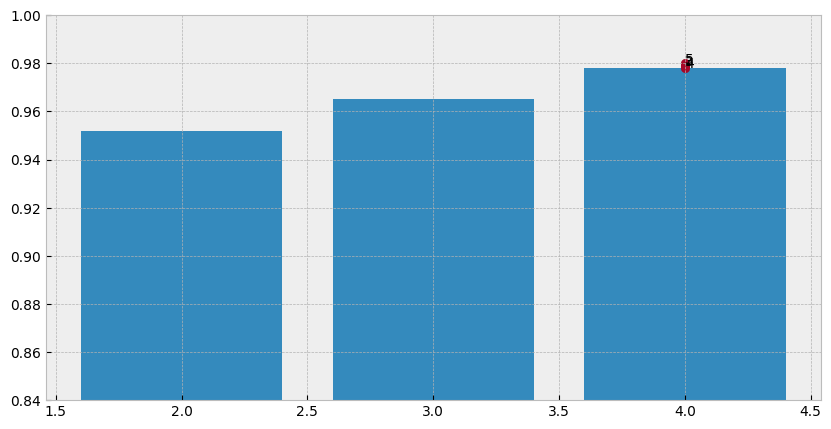

In [123]:
plt.subplots(figsize = (10,5))
plt.bar(degdf[degdf.Degree==3].NumLayers, degdf[degdf.Degree==3].Best_test)#, '-o', linestyle = '--')
plt.ylim(0.84, 1)
x, y = degdf[degdf.NumLayers==4].NumLayers, degdf[degdf.NumLayers==4].Best_test
plt.scatter(x,y)#, c = ['blue', 'green', 'red', 'orange'])
labels = ['3', '4', '5']
for i, label in enumerate(labels):
    plt.text(x.iloc[i], y.iloc[i], label)

C:\Users\shairozs\AppData\Local\Temp\1\ipykernel_37896\2257012805.py:8: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  axes[i].plot(d2.NumLayers, d2.Best_test, '-o', linestyle='--', c = cz[3])
C:\Users\shairozs\AppData\Local\Temp\1\ipykernel_37896\2257012805.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\shairozs\AppData\Local\Temp\1\ipykernel_37896\2257012805.py:8: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  axes[i].plot(d2.NumLayers, d2.Best_test, '-o', linestyle='--', c = cz[3])
C:\Users\shairozs\AppData\Local\Temp\1\ipykernel_37896\2257012805.py:27: UserWarning: No artists with labels

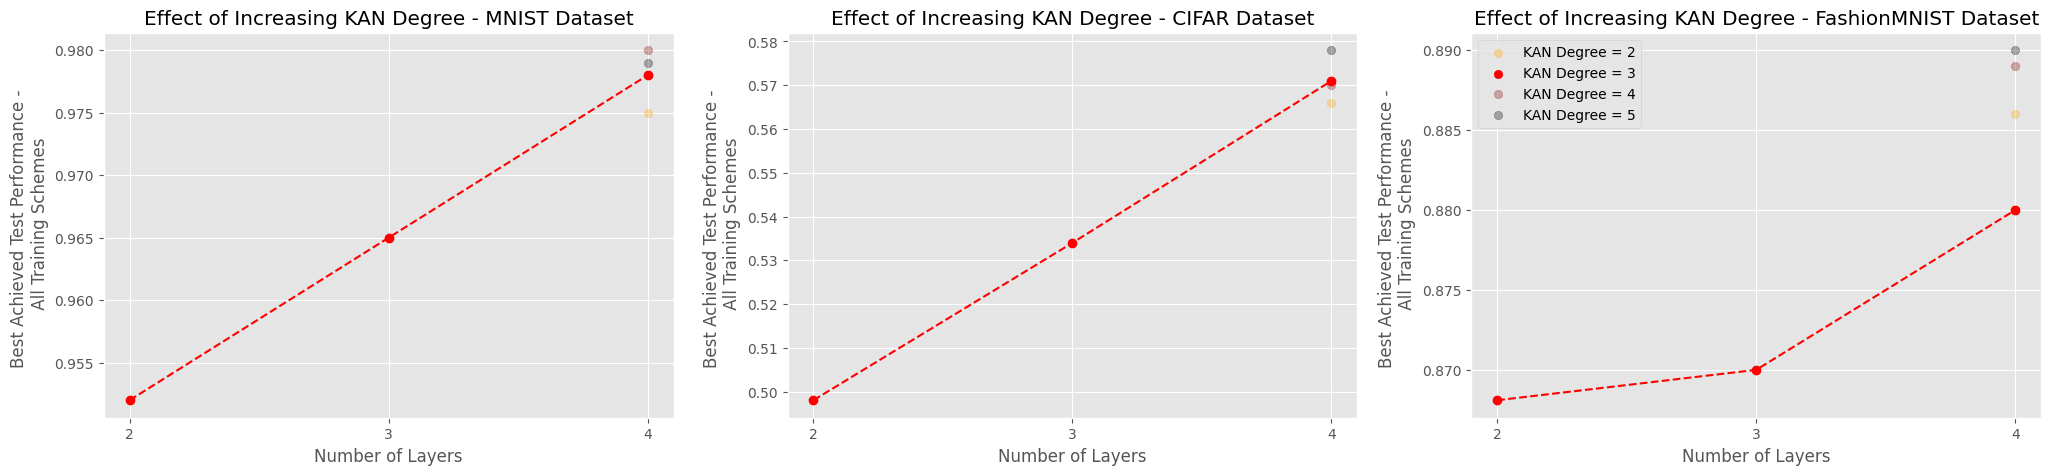

In [99]:
cz = ['a', 'yellow', 'orange', 'red', 'maroon', 'black']
al = 0.9
fig, axes = plt.subplots(1, 3, figsize = (25,5))
i = 0
for dataset in ['MNIST', 'CIFAR', 'FashionMNIST']:
    d2 = degdf[degdf.Degree == 3]
    d2 = d2[d2.Dataset == dataset]
    axes[i].plot(d2.NumLayers, d2.Best_test, '-o', linestyle='--', c = cz[3])
    axes[i].set_xticks([2,3,4])
    #plt.ylim(0.9, 1)
    
    
    d3 = degdf[degdf.NumLayers == 4]
    d3 = d3[d3.Dataset == dataset]
    for deg in d3.Degree.unique():
        d4 = d3[d3.Degree == deg]
        al = 1 if deg == 3 else 0.3
        axes[i].scatter(d4.NumLayers, d4.Best_test, label = "KAN Degree = " + str(deg), alpha = al, c = cz[deg])
    axes[i].set_xlabel("Number of Layers")# \n(Number of parameters when Degree = 3)")
    axes[i].set_ylabel("Best Achieved Test Performance - \n All Training Schemes")
    axes[i].set_title(f"Effect of Increasing KAN Degree - {dataset} Dataset")
    #labels = [item.get_text() for item in ax.get_xticklabels()]
    #labels[1] = 'Testing'
    labels = [2, 3, 4]
    #labels = ['2 (0.25m)', '3 (0.52m)', '4 (0.99m)']
    axes[i].set_xticks(ticks = [2,3,4], labels = labels)#, rotation = 45)
    plt.legend()
    i += 1

In [4]:
os.chdir('C:/Users/shairozs/Documents//Projects/HSIC_Bottleneck-Pytorch/')

In [1]:
import pandas as pd
import numpy as np
import os
print(os.getcwd())
RESULTS_FOLDER = '../Results/'
result_files = [os.path.join(RESULTS_FOLDER, x) for x in os.listdir(RESULTS_FOLDER) if x.endswith('.csv') and 'optimizer' in x]
#RESULTS_FOLDER = './Results2//'
#result_files += [os.path.join(RESULTS_FOLDER, x) for x in os.listdir(RESULTS_FOLDER) if x.endswith('.csv') and 'optimizer' in x]
result_rows = []
for r in result_files:
    
    filename = os.path.split(r)[-1]
    #print("Processing: ", filename)

    # Extract relevent information from filename
    params = filename.replace(".csv", "").split("_")
    dataset = params[0]
    
    backprop = params[1]
    model = params[2]
    num_layers = params[3]
    batchsize = int(params[5])
    lr = float(params[7])
    epochs = int(params[9])
    num_parameters = int(params[11])
    optimizer = params[13]
    init = '_'.join(params[15:17]) if len(params) > 14 else "kaiming_uniform"
    #print(init, "----------------")
    # Get best test performance and when it was reached
    try:
        data = pd.read_csv(r)
    except FileNotFoundError:
        print("Could not read: ", r)
        continue
    best_perf_test =  np.max(data['Test_loss'])
    best_perf_train = np.max(data['Train_loss'])
    best_perf_epoch_test = np.where(data['Test_loss'] == best_perf_test)[0][0]
    epochs = np.max(data['Epoch'])

    generalization = data['Train_loss'] - data['Test_loss']
    avg_gen = np.mean(generalization)
    # Get the average time taken per epoch
    avg_time = np.mean(data['Time'])

    result_rows.append([dataset, backprop, model, num_layers, batchsize, lr, epochs, num_parameters, 
                       optimizer, best_perf_train, best_perf_test, best_perf_epoch_test, avg_time, init, avg_gen])


df = pd.DataFrame(result_rows)
df.columns = ["Dataset", "Backprop", "Model", "Num_layers", "Batchsize", "LearningRate", "TotalEpochs", "Num_parameters",
              "Optimizer", "Best_train", "Best_test", "Best_test_at", "Avg_time", "Initialization", "AvgGenError"]

print(df.head())


C:\Users\shairozs\Documents\Projects\HSIC_Bottleneck-Pytorch\Notebooks
Could not read:  ../Results/MNIST_backprop_mlpWideWideWideWideWideWideWideWideWideWideWideWideWideWideWideWideWide_4layers_batchsize_4096_lr_0.0005_epochs_100_parameters_255050_optimizer_Adam_init_kaiming_normal_.csv
Could not read:  ../Results/MNIST_backprop_mlpWideWideWideWideWideWideWideWideWideWideWideWideWideWideWideWide_4layers_batchsize_4096_lr_0.0005_epochs_100_parameters_255050_optimizer_SGDM_init_kaiming_normal_.csv
Could not read:  ../Results/MNIST_backprop_mlpWideWideWideWideWideWideWideWideWideWideWideWideWideWideWide_4layers_batchsize_4096_lr_0.005_epochs_100_parameters_255050_optimizer_SGD_init_kaiming_normal_.csv
  Dataset  Backprop Model Num_layers  Batchsize  LearningRate  TotalEpochs  \
0   CIFAR  backprop   kan    2layers       2048        0.0005           98   
1   CIFAR  backprop   kan    2layers       2048        0.0005           98   
2   CIFAR  backprop   kan    2layers       2048        0.0

In [2]:
np.max(df[df.Dataset == 'MNIST'][df.Model=='kan'][df.Backprop=='backprop'][df.Num_layers == '4layers']['Num_parameters'])

C:\Users\shairozs\AppData\Local\Temp\1\ipykernel_8012\2430497313.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  np.max(df[df.Dataset == 'MNIST'][df.Model=='kan'][df.Backprop=='backprop'][df.Num_layers == '4layers']['Num_parameters'])
C:\Users\shairozs\AppData\Local\Temp\1\ipykernel_8012\2430497313.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  np.max(df[df.Dataset == 'MNIST'][df.Model=='kan'][df.Backprop=='backprop'][df.Num_layers == '4layers']['Num_parameters'])
C:\Users\shairozs\AppData\Local\Temp\1\ipykernel_8012\2430497313.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  np.max(df[df.Dataset == 'MNIST'][df.Model=='kan'][df.Backprop=='backprop'][df.Num_layers == '4layers']['Num_parameters'])


1109120

In [3]:
df = df[df.Model.apply(lambda x: len(x)) <= 9]
df['Optimizer'] = pd.Series([x.rstrip() for x in df.Optimizer])
#df['Model'] = df['Model'].apply(lambda x: x[:7])

df['ModelType'] = df['Model'] + "_" + df['Num_layers']

## Populate Intrinsic Dimension
conditions = [
    (df['Dataset']=='MNIST'),
    (df['Dataset'] == 'CIFAR')]
choices = [750, 9000]
df['ID'] = np.select(conditions, choices)

df['Efficiency'] = (df['Best_test'] / (df['Best_test_at'] + 1))*(1/np.log( 1 + df['Num_parameters'] - df['ID']))
#df = df[df.TotalEpochs > 90 or df.Dataset=='higgs']# & (df.Dataset == 'MNIST')]#print(df.TotalEpochs> 90)
#df = df[df.TotalEpochs == 100]
#df.sort_values('Best_test')
df.sort_values('Efficiency')

,Dataset,Backprop,Model,Num_layers,Batchsize,LearningRate,TotalEpochs,Num_parameters,Optimizer,Best_train,Best_test,Best_test_at,Avg_time,Initialization,AvgGenError,ModelType,ID,Efficiency
1085,MNIST,HSIC,kan,4layers,2048,0.0050,98,1109588,SGD,0.189504,0.181396,48,27.242256,kaiming_uniform,0.004731,kan_4layers,750,0.000266
1086,MNIST,HSIC,kan,4layers,2048,0.0050,98,1109588,SGD,0.257914,0.265503,46,28.159566,orthogonal_,-0.009016,kan_4layers,750,0.000406
1068,MNIST,HSIC,kan,3layers,2048,0.0050,98,525652,SGD,0.274734,0.273438,49,12.614529,orthogonal_,0.000583,kan_3layers,750,0.000415
1066,MNIST,HSIC,kan,3layers,2048,0.0050,98,525652,SGD,0.308930,0.289551,49,12.527572,kaiming_normal,0.012521,kan_3layers,750,0.000440
195,CIFAR,hsic,kan,3layers,1024,0.0050,98,17066516,SGDM,0.369710,0.372721,48,125.980922,kaiming_normal,-0.002677,kan_3layers,9000,0.000457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461,higgs,backprop,mlp,3layers,10000,0.0005,4,148226,SGDM,4982.471700,4982.139000,1,297.438660,orthogonal_,0.371800,mlp_3layers,0,209.219289
463,higgs,backprop,mlp,3layers,10000,0.0050,4,148226,Adam,5001.741000,5001.595000,1,294.248245,orthogonal_,0.219333,mlp_3layers,0,210.036322
437,higgs,backprop,mlp,2layers,10000,0.0005,4,8450,SGDM,4977.347000,4977.073000,1,288.292826,orthogonal_,0.383433,mlp_2layers,0,275.218478
438,higgs,backprop,mlp,2layers,10000,0.0005,4,8450,SGD,4977.597700,4977.119000,0,288.158509,orthogonal_,0.583533,mlp_2layers,0,550.442043


In [4]:
print(df.Dataset.unique())

['CIFAR' 'Fashion' 'higgs' 'IMDB' 'MNIST']


In [7]:
df['ModelType'].unique()

array(['kan_2layers', 'kan_3layers', 'kan_4layers', 'mlpWide_2layers',
       'mlpWide_3layers', 'mlpWide_4layers', 'mlp_2layers', 'mlp_3layers',
       'mlp_4layers'], dtype=object)

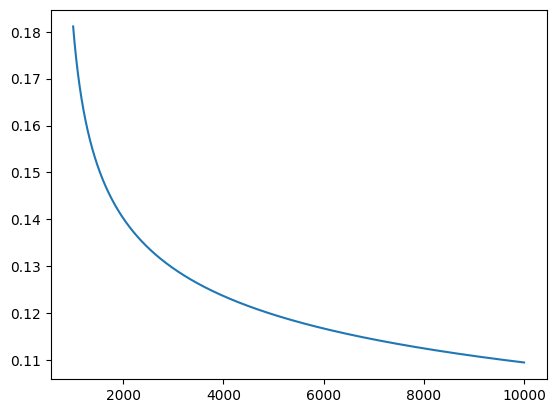

In [23]:
ax = [x for x in range(1000, 10000)]
ay = [1 / np.log(x - 750) for x in ax]
plt.plot(ax, ay)

In [12]:
os.getcwd()

'C:\\Users\\shairozs\\Documents\\Projects'

In [22]:
import os
#os.chdir('./HSIC_Bottleneck-Pytorch/')
from Code.Trainers import HSICBottleneck, Backprop
from Code.Models import MLP, ChebyKAN, KAN
from Code.Data import load_data
from Code.Utils import show_result
import time
import torch; torch.manual_seed(1)
from torch import optim
import pandas as pd
from torch import nn

batchsize = 2048
#train_loader, test_loader = load_data(dataset = 'higgs', batchsize=batchsize)
train_loader, test_loader = load_data(dataset = 'higgs', batchsize=batchsize, 
                                          test_path = r'./data/higgs/HIGGS.csv', train_path = r'./data/higgs/HIGGS.csv')
epochs = 100
loss = "CE" #"mse"
device = "cuda"
dropout = 0.2
degree = 3
trainer_ = Backprop
batchnorm = 1
wide = 1
activation = nn.SiLU()

# Entropy is the number of states
# Entropy increases when information is lost
# With time, entropy decreases
# Increasing entropy requires information
# Information requires energy

for model_name in ['mlp']:

    #wide = 0 if 'mlp' not in model_name else wide

    
    #for layer_sizes in [[784, 32], [784, 64, 32], [784, 128, 64, 32]]:
    for layer_sizes in [[28, 256], [28, 512, 256], [28, 1024, 512, 256]]:
        if wide:
            layer_sizes = [10*x if x!=784 else x for x in layer_sizes]
            model_name = 'mlpWide'
        model = MLP(layer_sizes = layer_sizes, output_size = 2, dropout = dropout, batchnorm = batchnorm)

        
        model = model.to(device)
        print("Model: ", model_name)
        print("Layer sizes: ", layer_sizes)
        num_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad); print("Model trainable parameters: ", num_parameters)
        print("------------------------------")
        continue

C:\Users\shairozs\Documents\Projects\HSIC_Bottleneck-Pytorch
Model:  mlpWide
Layer sizes:  [280, 2560]
Model trainable parameters:  729602
------------------------------
Model:  mlpWide
Layer sizes:  [280, 5120, 2560]
Model trainable parameters:  14568962
------------------------------
Model:  mlpWide
Layer sizes:  [280, 10240, 5120, 2560]
Model trainable parameters:  68462082
------------------------------


In [7]:
os.getcwd()

'C:\\Users\\shairozs\\Documents\\Projects\\HSIC_Bottleneck-Pytorch\\Notebooks'

In [5]:
df.to_csv('results_compiled.csv')

Text(0.5, 1.0, 'Test Acc under Backprop Training Schemes')

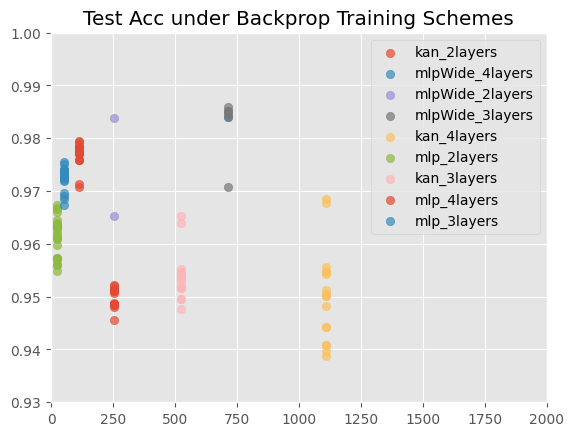

In [28]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
for model in set(np.unique(df['ModelType'])):
    sa = df[(df.ModelType ==model)]
    plt.scatter(sa.Num_parameters/1000, sa.Best_test, marker = 'o', label = model, alpha = 0.7)#, s =10)
plt.ylim(0.93, 1)
plt.xlim(-2, 2000)
plt.legend()
plt.title("Test Acc under Backprop Training Schemes")
#for i in set(sa.Num_layers):
#    print(i)
#    plt.plot(sa[sa.Num_layers==i].Best_test, label = i)
#sa = sa[sa.Optimizer == 'AdamW']
#sa = sa[sa.LearningRate == 

In [7]:
df.Dataset.unique()

array(['CIFAR', 'Fashion', 'MNIST'], dtype=object)

Text(0.5, 1.0, 'Avg. Epoch Time under Backprop Training Schemes')

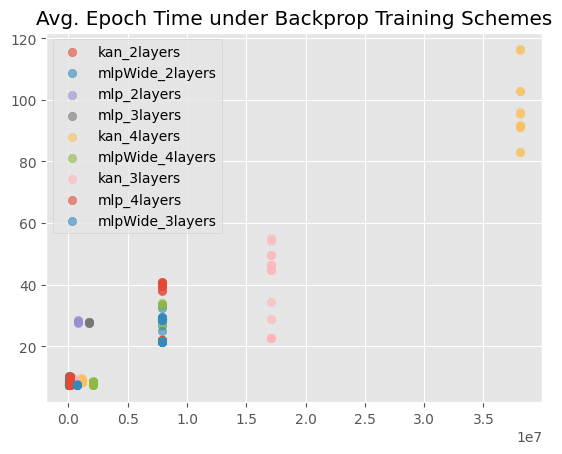

In [149]:
import matplotlib.pyplot as plt
for model in set(np.unique(df['ModelType'])):
    sa = df[(df.ModelType ==model)]
    plt.scatter(sa.Num_parameters, sa.Avg_time, marker = 'o', label = model, alpha = 0.6)
plt.legend()
plt.title("Avg. Epoch Time under Backprop Training Schemes")

Text(0.5, 1.0, 'Parameters vs Efficiency under Backprop Training Schemes')

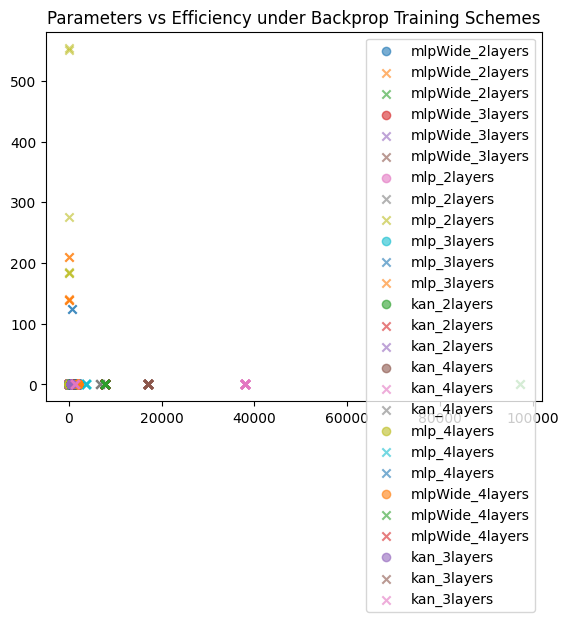

In [25]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots()
for model in set(np.unique(df['ModelType'])):
    sa = df[(df.ModelType ==model)]
    for dataset in ['MNIST', 'CIFAR', 'higgs']:
        mark = 'o' if dataset=='MNIST' else 'x'
        g = sa[sa.Dataset == dataset]
        axes.scatter(g.Num_parameters/1000, g.Efficiency, marker = mark, label = model, alpha = 0.6)
plt.legend()
plt.title("Parameters vs Efficiency under Backprop Training Schemes")

Text(0.5, 1.0, 'Best Test Acc Under All Training Schemes')

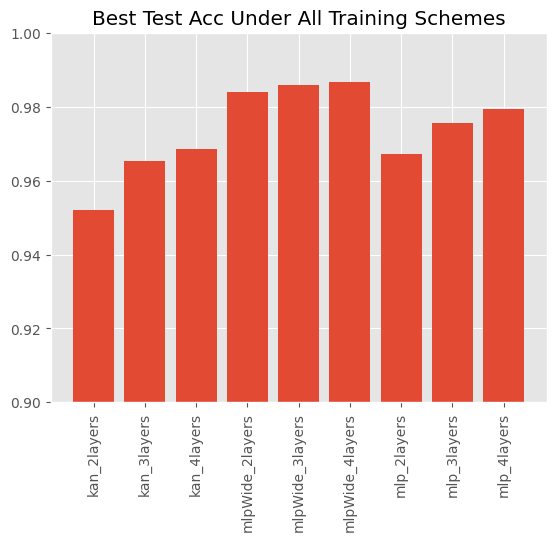

In [9]:
zs = df.groupby("ModelType", group_keys=True)[['Best_test']].max()
plt.bar(zs.index, zs.Best_test); plt.ylim(0.9,1)
plt.xticks(rotation = 90)
plt.title("Best Test Acc Under All Training Schemes")

Text(0.5, 1.0, 'Best Test Acc Under All Training Schemes')

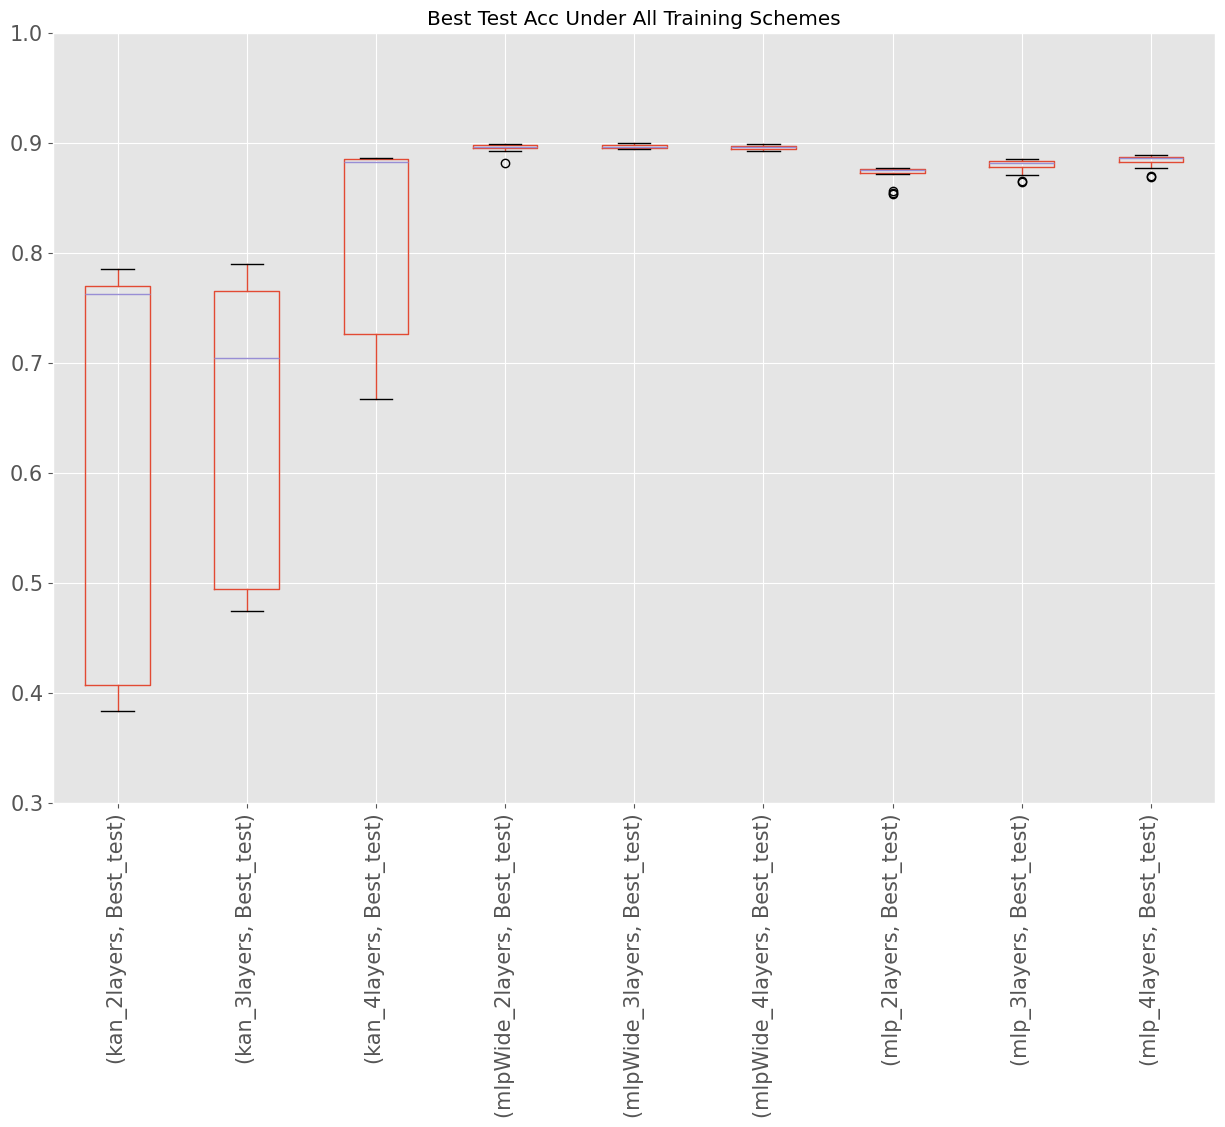

In [10]:
zs = df[df.Dataset == 'Fashion']
zs = zs.groupby("ModelType", group_keys=True)[['Best_test']]

zs.boxplot(figsize = (15,10), fontsize = 15,  subplots = 0)
plt.xticks(rotation = 90)
plt.ylim(0.30, 1)
plt.title("Best Test Acc Under All Training Schemes")
#plt.ylim(0.45, 0.6)
#plt.box(zs.index, zs.Best_test); plt.ylim(0.75,1)


Text(0.5, 1.0, 'Best Test Acc Under All Training Schemes')

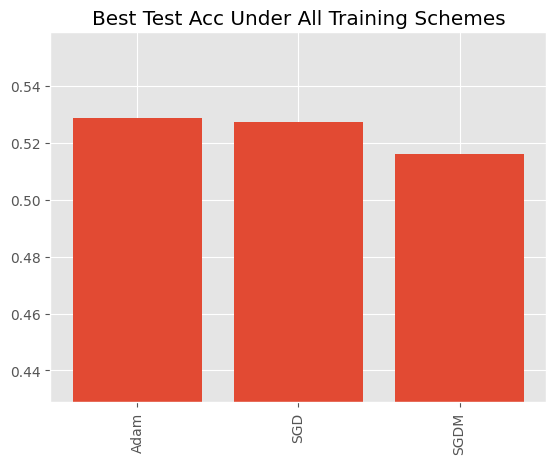

In [12]:
grouper = 'Optimizer'
response = 'Best_test'
#zs = df.groupby("Optimizer", group_keys=True)[['Best_test', 'ModelType']]
zs = df[df.Dataset == 'CIFAR']
zs = zs[['kan' in c for c in list(zs['ModelType'])]][[grouper,response]]
zs = zs.groupby(grouper, group_keys=True)[[response]].median()
plt.bar(zs.index, zs.Best_test); 
m = np.max(zs.Best_test); plt.ylim(m - .1,m + 0.03)
plt.xticks(rotation = 90)
plt.title("Best Test Acc Under All Training Schemes")
#plt.bar(zs.index, zs.Best_test); plt.ylim(0.75,1)
#plt.xticks(rotation = 90)
#plt.title("Best Test Acc Under All Training Schemes")

In [133]:
df.Dataset.unique()

array(['CIFAR', 'Fashion', 'MNIST'], dtype=object)